# Learning Uncertainty Sets

In [1]:
import cvxpy as cp
import scipy as sc
import numpy as np
import numpy.random as npr
import torch
from sklearn import datasets
import pandas as pd
import lropt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
import sys
# import ot
sys.path.append('..')
from utils import plot_iters, plot_coverage_all
warnings.filterwarnings("ignore")
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":18,
    "font.family": "serif"
})
colors = ["tab:blue", "tab:green", "tab:orange", 
          "blue", "tab:purple", "tab:brown", "tab:pink", "tab:grey", "red"]

### Example 3: Affine Adjustable Robust Optimization: Inventory management

We solve the robust optimization problem given as 
\begin{equation*}
	\begin{array}{ll}
		\text{minimize} & L\\
		\text{subject to} & -r^Ty^0 - r^TYu + (t+h)^Ts \le L, \quad \forall u\in \mathcal{U}(\mathcal{D}_N,\theta)\\
		& y^0_i + y_i^Tu\leq s_i, \quad i = 1, \dots, N, \quad \forall u\in \mathcal{U}(\mathcal{D}_N,\theta)\\
		& y^0_i + y_i^Tu \leq d_i^0 + q_i^Tu, \quad i = 1, \dots, N, \quad \forall u\in \mathcal{U}(\mathcal{D}_N,\theta)\\
			& \mathbf{1}^Ts = C\\
			& s \leq c\\
			& s \geq 0.
	\end{array}
\end{equation*}


In [2]:
def data_scaled(N, m, scale, seed):
    np.random.seed(seed)
    R = np.vstack([np.random.normal(
        i*0.03*scale, np.sqrt((0.02**2+(i*0.1)**2)), N) for i in range(1, m+1)])
    return (R.transpose())

def data_modes(N, m, scales, seed):
    modes = len(scales)
    d = np.zeros((N+100, m))
    weights = int(np.ceil(N/modes))
    for i in range(modes):
        d[i*weights:(i+1)*weights,
          :] = data_scaled(weights, m, scales[i], seed)
    return d[0:N, :]

n = 10
m = 4

r = np.random.uniform(2,4,n)
scenarios = {}
num_scenarios = 5
for scene in range(num_scenarios):
    np.random.seed(scene)
    scenarios[scene] = {}
    scenarios[scene][0] = r + np.random.normal(0,0.1,n)

np.random.seed(27)
C = 200
c = np.random.uniform(30,50,n)
Q = np.random.uniform(-0.2,0.2,(n,m))
d = np.random.uniform(10,20,n)
t = np.random.uniform(0.1,0.3,n)
h = np.random.uniform(0.1,0.3,n)

In [14]:
# saved_s = np.load("scenarios.npy")
# num_scenarios = 5
# y_data = saved_s[0]
# for scene in range(1,num_scenarios):
#     y_data = np.vstack([y_data,saved_s[scene]])

n = 10
m = 4
N=100
test_p = 0.2
np.random.seed(27)
y_nom = np.random.uniform(2,4,n)
y_data = y_nom
num_scenarios = 9
for scene in range(num_scenarios):
    np.random.seed(scene)
    y_data = np.vstack([y_data,np.maximum(y_nom + np.random.normal(0,0.05,n),0)])
seed = 0
newdata = data_modes(20000,m,[1,2,3],seed = 10000+seed)
num_reps = int(N/10)
y_data1 = np.vstack([y_data]*num_reps)
num_reps2 = int(20000/10)
new_y_data = np.vstack([y_data]*num_reps2)

data = data_modes(N,m,[1,2,3],seed = seed)
train, test = train_test_split(data, test_size=int(
data.shape[0]*test_p), random_state=seed)
init = np.real(sc.linalg.sqrtm(np.cov(train.T)))
init_bval = np.mean(train, axis=0)

# formulate the ellipsoidal set
u = lropt.UncertainParameter(m,
                                uncertainty_set = lropt.Ellipsoidal(p=2, data =data))
# u = lropt.UncertainParameter(m,
#                                         uncertainty_set = lropt.MRO(K=train.shape[0], p=2, data=train, train=True))
# formulate cvxpy variable
L = cp.Variable()
s = cp.Variable(n)
y = cp.Variable(n)
Y = cp.Variable((n,m))
r = lropt.Parameter(n, data = y_data1)        

# formulate objective
objective = cp.Minimize(L)

# formulate constraints
constraints = [cp.maximum(-r@y - r@Y@u + (t+h)@s - L, y[0]+Y[0]@u -s[0],y[1]+Y[1]@u -s[1],y[2]+Y[2]@u -s[2],y[3]+Y[3]@u -s[3],y[4]+Y[4]@u -s[4],y[5]+Y[5]@u -s[5],y[6]+Y[6]@u -s[6],y[7]+Y[7]@u -s[7], y[8]+Y[8]@u -s[8],y[9]+Y[9]@u -s[9],y[0] - d[0] - (Q[0] - Y[0])@u,y[1] - d[1] - (Q[1] - Y[1])@u,y[2] - d[2] - (Q[2] - Y[2])@u ,y[3] - d[3] - (Q[3] - Y[3])@u,y[4] - d[4] - (Q[4] - Y[4])@u,y[5] - d[5] - (Q[5] - Y[5])@u,y[6] - d[6] - (Q[6] - Y[6])@u,y[7] - d[7] - (Q[7] - Y[7])@u,y[8] - d[8] - (Q[8] - Y[8])@u,y[9] - d[9] - (Q[9] - Y[9])@u ) <= 0]
# constraints = [-r@y - r@Y@u + (t+h)@s <= L]
# for i in range(n):
#     constraints += [y[i]+Y[i]@u <= s[i]]
#     constraints += [y[i]<= d[i]+ (Q[i] - Y[i])@u]
constraints += [np.ones(n)@s == C]
constraints += [s <=c, s >=0]
eval_exp = -r@y - r@Y@u + (t+h)@s
# formulate Robust Problem
prob = lropt.RobustProblem(objective, constraints,eval_exp = eval_exp )


In [23]:
# solve
# seed 1, 
warnings.filterwarnings("ignore")
result = prob.train(lr = 0.0001,num_iter=200, optimizer = "SGD", seed = seed, init_A = init, init_b = init_bval, init_lam = 2, init_mu = 2, mu_multiplier=1.02, init_alpha = 0.0, test_percentage = test_p, save_history = False, lr_step_size = 50, lr_gamma = 0.5, position = False, random_init = False, num_random_init=5, parallel = True, kappa=0, eta=0.1)
A_fin = result.A
b_fin = result.b

# ts = []
# for i in range(1):
#     prob.solve()
#     ts.append(prob.solver_stats.solve_time)
# np.mean(ts)

/Users/irina.wang/anaconda3/envs/lropt_s/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/anaconda3/envs/lropt_s/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
 

In [20]:
result5 = prob.grid(epslst = np.linspace(0.001,8, 10), init_A = A_fin, init_b = b_fin, seed = seed, init_alpha = 0., test_percentage = test_p, newdata = (newdata, new_y_data))
dfgrid2 = result5.df

In [21]:
# Grid search epsilon
result4 = prob.grid(epslst = np.linspace(0.001,8, 10), init_A = init, init_b = init_bval, seed = seed, init_alpha = 0., test_percentage =test_p,newdata = (newdata, new_y_data))
dfgrid = result4.df

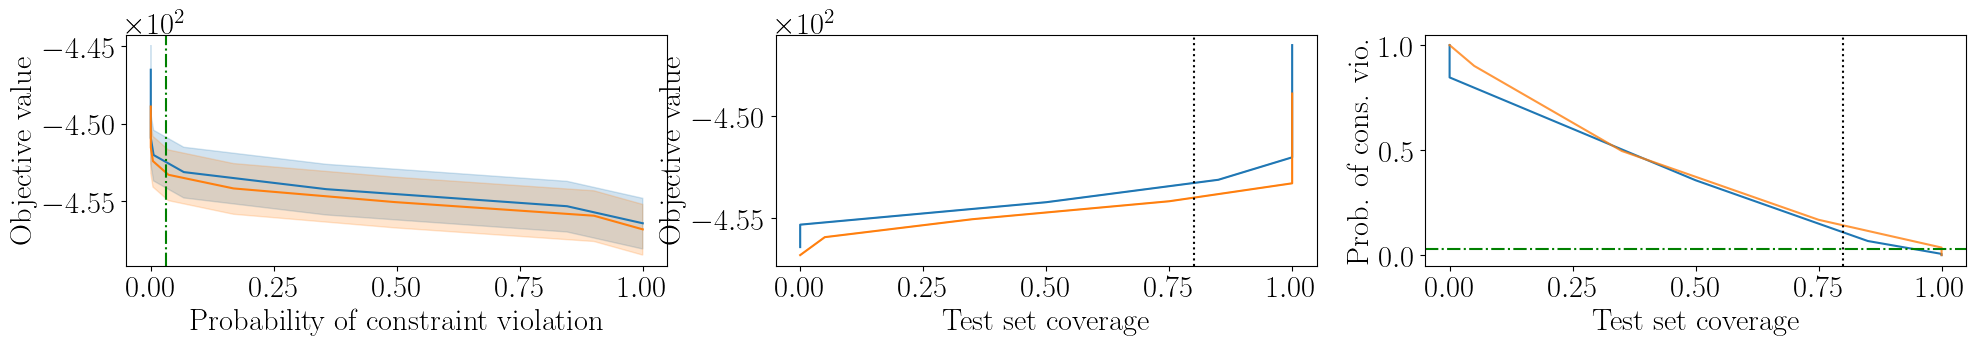

In [22]:
plot_coverage_all(dfgrid,dfgrid2,None, "inventory_4",ind_1=(0,100),ind_2=(0,100), logscale = False)

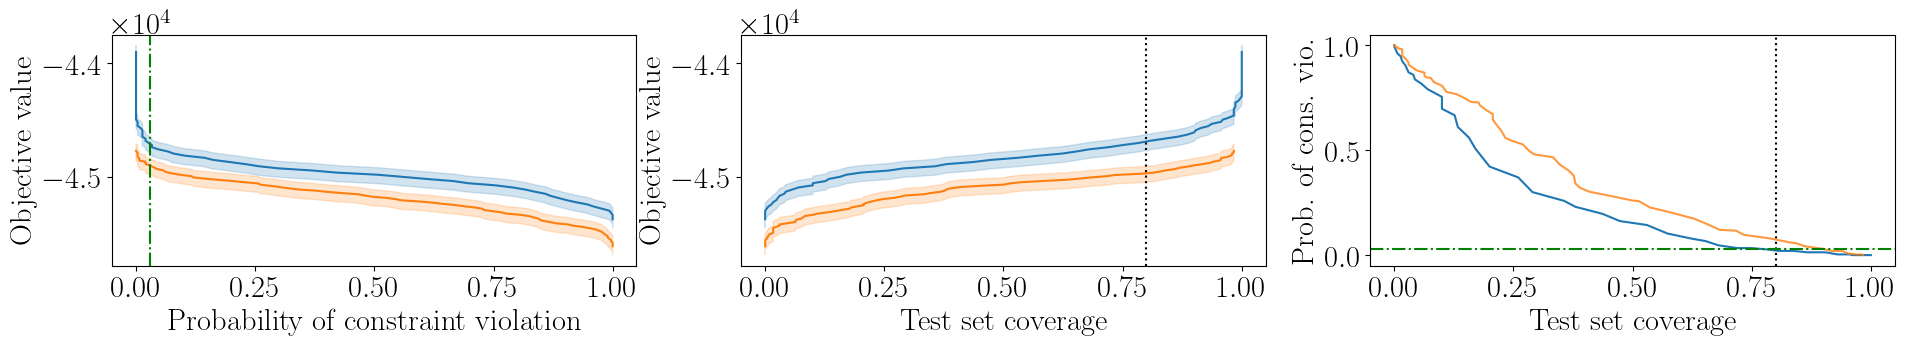

In [ ]:
# seed 1, aug
plot_coverage_all(dfgrid,dfgrid2,None, "inventory_4",ind_1=(0,100),ind_2=(0,100), logscale = False)

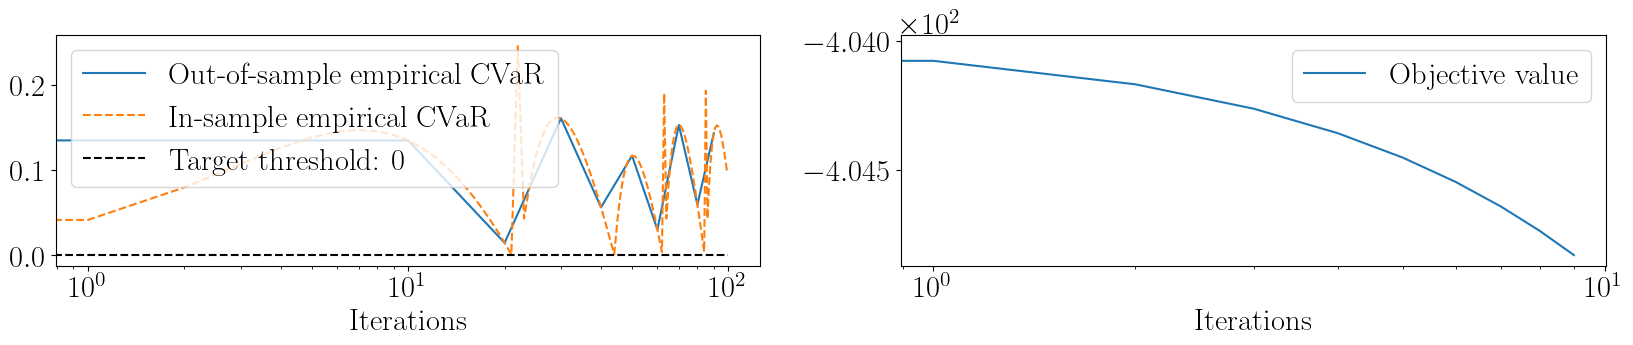

In [ ]:
plot_iters(result.df, result.df_test,"inventory_log", logscale = True, steps = 1000)

In [ ]:
prob_list = np.array([0.,0.01,0.05,0.1])
inds_standard = []
inds_reshaped = []
for i in prob_list:
    inds_standard.append(np.absolute(np.mean(np.s(dfgrid['Violations']),axis = 1)-i).argmin())
    inds_reshaped.append(np.absolute(np.mean(np.vstack(dfgrid2['Violations']),axis = 1)-i).argmin())
st_eps = np.linspace(0.01, 1.5, 40)[inds_standard[0]]
re_eps = np.linspace(0.01, 1.5, 40)[inds_reshaped[0]]
st_eps, re_eps

(0.8505128205128205, 1.308974358974359)